In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project-crimerates/Chicago_Crimes_Cleaned.csv
/kaggle/input/holidays/US Holiday Dates (2004-2021).csv


In [2]:
import tensorflow as tf

# Check GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is Available! Using GPU for Deep Learning Models.")
else:
    print("⚠ No GPU found! Running on CPU.")


Num GPUs Available: 2
✅ GPU is Available! Using GPU for Deep Learning Models.


**Crime Volume Trends (Forecast Future Crime Counts)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dataset
df_crime = pd.read_csv("/kaggle/input/project-crimerates/Chicago_Crimes_Cleaned.csv")

# Convert 'Date' to datetime
df_crime['Date'] = pd.to_datetime(df_crime['Date'])

# Aggregate crimes per year
df_yearly = df_crime.resample('Y', on='Date').size().reset_index()
df_yearly.columns = ['ds', 'y']

# Normalize Data
scaler = MinMaxScaler()
df_yearly['y'] = scaler.fit_transform(df_yearly[['y']])

# Prepare Data for LSTM
n_timesteps = 10
X, y = [], []

for i in range(len(df_yearly) - n_timesteps):
    X.append(df_yearly['y'].values[i:i+n_timesteps])
    y.append(df_yearly['y'].values[i+n_timesteps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define Optimized LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_timesteps, 1)),
    LSTM(50, activation='relu'),
    Dense(1, activation='relu')  # Ensures positive predictions
])

model_lstm.compile(optimizer='adam', loss='mse')

# Train Model with More Epochs & Larger Batch Size
model_lstm.fit(X, y, epochs=50, batch_size=32, verbose=1)

# Forecast Next Year
X_test = df_yearly['y'].values[-n_timesteps:].reshape((1, n_timesteps, 1))
lstm_prediction = model_lstm.predict(X_test)

# Convert Prediction Back to Original Scale
lstm_prediction_original = scaler.inverse_transform(lstm_prediction)
print("LSTM Crime Volume Prediction (Next Year):", lstm_prediction_original)


<ipython-input-1-334388acd76d>:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_crime.resample('Y', on='Date').size().reset_index()
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0993
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0898
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0809
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0726
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0650
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0584
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0523
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0466
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0413
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0363
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0314
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0269
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0228
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0193
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0164
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

14:00:37 - cmdstanpy - INFO - Chain [1] start processing
14:00:37 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


<Figure size 1200x600 with 0 Axes>

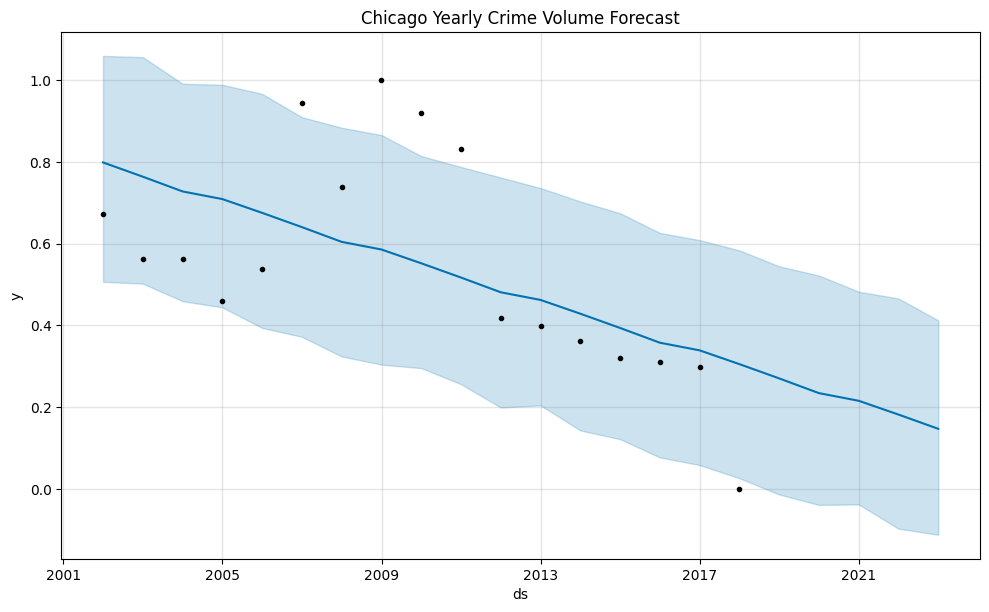

In [2]:
from prophet import Prophet

# Train Prophet Model
model_prophet = Prophet()
model_prophet.fit(df_yearly)

# Forecast next 5 years
future = model_prophet.make_future_dataframe(periods=5, freq='Y')
forecast = model_prophet.predict(future)

# Plot Predictions
plt.figure(figsize=(12, 6))
model_prophet.plot(forecast)
plt.title("Chicago Yearly Crime Volume Forecast")
plt.show()


14:01:03 - cmdstanpy - INFO - Chain [1] start processing
14:01:03 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


<Figure size 1200x600 with 0 Axes>

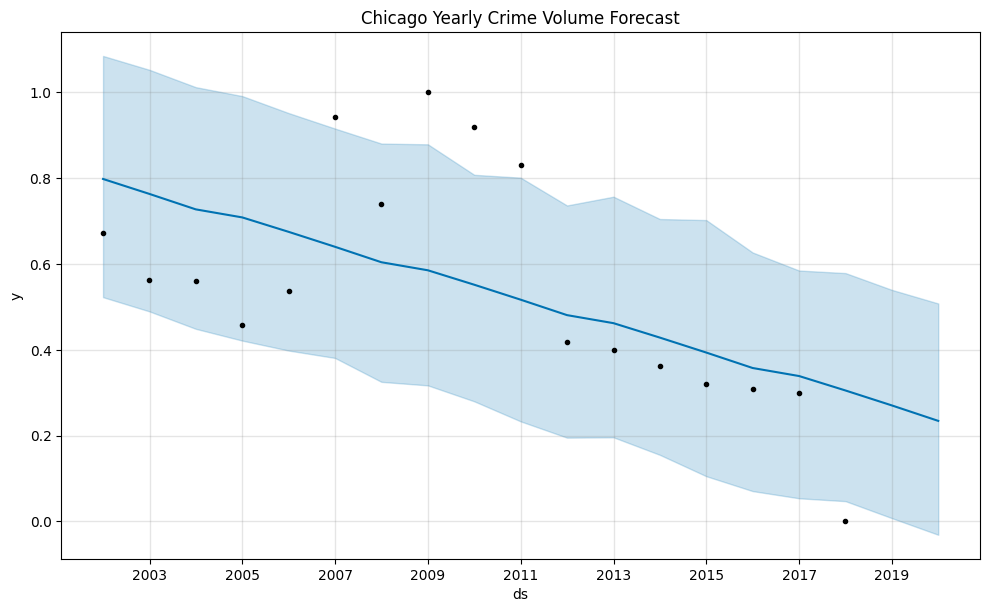

In [3]:
from prophet import Prophet

# Train Prophet Model
model_prophet = Prophet()
model_prophet.fit(df_yearly)

# Forecast next 2 years
future = model_prophet.make_future_dataframe(periods=2, freq='Y')
forecast = model_prophet.predict(future)

# Plot Predictions
plt.figure(figsize=(12, 6))
model_prophet.plot(forecast)
plt.title("Chicago Yearly Crime Volume Forecast")
plt.show()

In [6]:
import folium
from folium.plugins import HeatMap

# Sample 5000 crimes for performance
df_sample = df_crime.sample(n=5000, random_state=42)

# Initialize Map
crime_map = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add Heatmap Layer
heat_data = list(zip(df_sample['Latitude'], df_sample['Longitude']))
HeatMap(heat_data, radius=10).add_to(crime_map)

# Save Map
crime_map.save("/kaggle/working/Crime_Hotspot_Map.html")

print("✅ Crime Hotspot Map Saved. Download it from Kaggle's Output Section.")


✅ Crime Hotspot Map Saved. Download it from Kaggle's Output Section.


In [2]:
!pip uninstall -y xgboost
!pip install xgboost --no-cache-dir

Found existing installation: xgboost 2.0.3
Uninstalling xgboost-2.0.3:
  Successfully uninstalled xgboost-2.0.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 229.1 MB/s eta 0:00:0000:0100:01


**Anomaly Detection (Crime Spikes in Districts)**

In [13]:
df_crime = df_crime[df_crime['Date'].dt.year != 2017]

<ipython-input-18-9ed5f8f7f483>:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_crime.resample('Y', on='Date').size().reset_index()
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Detected Crime Spikes Yearly:
           ds       y  Anomaly Score
7 2008-12-31  839525             -1


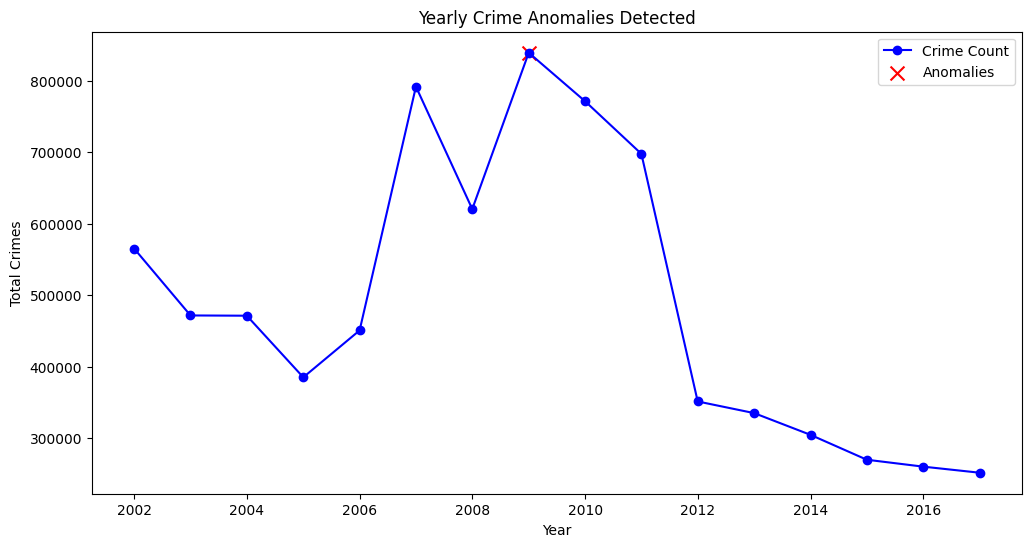

In [18]:
from sklearn.ensemble import IsolationForest

# Aggregate Crimes per Year (Without 2017)
df_yearly = df_crime.resample('Y', on='Date').size().reset_index()
df_yearly.columns = ['ds', 'y']

# Train Isolation Forest
model_iforest = IsolationForest(contamination=0.02, random_state=42)
df_yearly['Anomaly Score'] = model_iforest.fit_predict(df_yearly[['y']])

# Identify Anomalous Years
anomalies = df_yearly[df_yearly['Anomaly Score'] == -1]
print("Detected Crime Spikes Yearly:\n", anomalies)



# Plot Crime Trends & Anomalies
plt.figure(figsize=(12,6))
plt.plot(df_yearly['ds'], df_yearly['y'], label='Crime Count', color='blue', marker='o')
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', marker='x', s=100)
plt.xlabel('Year')
plt.ylabel('Total Crimes')
plt.title('Yearly Crime Anomalies Detected')
plt.legend()
plt.show()


In [15]:
df_crime[df_crime['Date'].dt.year == 2008].shape


(839525, 19)

In [16]:
df_crime[df_crime['Date'].dt.year == 2008].groupby('Primary Type').size().sort_values(ascending=False)

Primary Type
THEFT                               172810
BATTERY                             150918
CRIMINAL DAMAGE                     104402
NARCOTICS                            90130
OTHER OFFENSE                        52234
BURGLARY                             52022
ASSAULT                              50543
MOTOR VEHICLE THEFT                  37251
ROBBERY                              33180
DECEPTIVE PRACTICE                   28562
CRIMINAL TRESPASS                    24442
PROSTITUTION                         10178
WEAPONS VIOLATION                     7652
PUBLIC PEACE VIOLATION                5986
OFFENSE INVOLVING CHILDREN            4861
CRIM SEXUAL ASSAULT                   2819
SEX OFFENSE                           2778
GAMBLING                              2356
LIQUOR LAW VIOLATION                  1798
ARSON                                 1286
INTERFERENCE WITH PUBLIC OFFICER      1148
KIDNAPPING                             714
INTIMIDATION                           51

In [17]:
df_yearly[df_yearly['ds'].dt.year.isin([2007, 2008, 2009])]

,ds,y,Anomaly Score
6,2007-12-31,620524,1
7,2008-12-31,839525,-1
8,2009-12-31,771587,1


**Impact of External Events (Weather, Holidays & Crime)**

In [5]:
import pandas as pd

# Load Holiday Dataset
df_holidays = pd.read_csv("/kaggle/input/holidays/US Holiday Dates (2004-2021).csv")

# Convert 'Date' to datetime format
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])

# Keep only relevant columns
df_holidays = df_holidays[['Date', 'Holiday']]  # Only keep Date & Holiday Name
print(df_holidays.head())  # Check the data
last_5_rows = df_holidays.tail(5)
print(last_5_rows)

        Date      Holiday
0 2004-07-04  4th of July
1 2005-07-04  4th of July
2 2006-07-04  4th of July
3 2007-07-04  4th of July
4 2008-07-04  4th of July
          Date         Holiday
337 2006-04-16  Western Easter
338 2017-04-16  Western Easter
339 2014-04-20  Western Easter
340 2019-04-21  Western Easter
341 2011-04-24  Western Easter


In [18]:
import xgboost as xgb
print("XGBoost Built with GPU:", xgb.__version__)
print("XGBoost GPU Support:", xgb.get_config())


XGBoost Built with GPU: 2.0.3
XGBoost GPU Support: {'use_rmm': False, 'verbosity': 1}


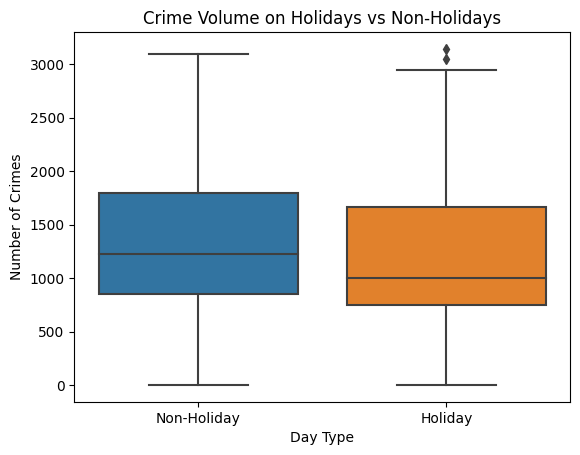


Average Crime Counts:
Non-Holiday: 1342.6918967052538
Holiday: 1215.1352459016393

T-test Results:
T-statistic: -3.105755402745247
P-value: 0.0021050771656765453
✅ Statistically Significant Difference in Crime Rates on Holidays


<ipython-input-6-5204727da4bb>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Non-Holiday:', mean_counts[0])
<ipython-input-6-5204727da4bb>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Holiday:', mean_counts[1])


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

holiday_data = pd.read_csv('/kaggle/input/holidays/US Holiday Dates (2004-2021).csv')  # Replace with your holiday CSV filename
holiday_data['Date'] = pd.to_datetime(holiday_data['Date'])
holiday_dates = holiday_data['Date'].dt.date.tolist()

crime_data = pd.read_csv('/kaggle/input/project-crimerates/Chicago_Crimes_Cleaned.csv', parse_dates=['Date'])  # Replace with your file & date column
crime_data['CrimeDateOnly'] = crime_data['Date'].dt.date  # Extract only date (drop time)

crime_data['IsHoliday'] = crime_data['CrimeDateOnly'].isin(holiday_dates)

daily_crime = crime_data.groupby(['CrimeDateOnly', 'IsHoliday']).size().reset_index(name='CrimeCount')

sns.boxplot(x='IsHoliday', y='CrimeCount', data=daily_crime)
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.title('Crime Volume on Holidays vs Non-Holidays')
plt.xlabel('Day Type')
plt.ylabel('Number of Crimes')
plt.show()


mean_counts = daily_crime.groupby('IsHoliday')['CrimeCount'].mean()
print('\nAverage Crime Counts:')
print('Non-Holiday:', mean_counts[0])
print('Holiday:', mean_counts[1])


holiday_crimes = daily_crime[daily_crime['IsHoliday'] == True]['CrimeCount']
nonholiday_crimes = daily_crime[daily_crime['IsHoliday'] == False]['CrimeCount']

t_stat, p_value = ttest_ind(holiday_crimes, nonholiday_crimes, equal_var=False)

print('\nT-test Results:')
print('T-statistic:', t_stat)
print('P-value:', p_value)

if p_value < 0.05:
    print('✅ Statistically Significant Difference in Crime Rates on Holidays')
else:
    print('❌ No Statistically Significant Difference in Crime Rates on Holidays')

